# MARL - CITY ON FIRE

Google Colab Notebook with network weights saved in the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gym
import time
import random
from collections import deque
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten
from keras.optimizers import Adam, RMSprop, SGD

Using TensorFlow backend.


# DQN for Choosing Actions:
(Move, Use Water Jet, Call For Help, Disengage from target)

In [0]:
def new_act_net():
    model = Sequential()
    model.add(Dense(8, input_shape = (4,), activation = 'relu'))
    model.add(Dense(4, activation = 'relu'))
    model.add(Dense(4, activation = 'softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(), metrics = ['accuracy'])
    #model.summary()

    return model

In [0]:
net = new_act_net()
net.load_weights('/content/drive/My Drive/Colab Notebooks/New_Act_Policy_V3.h5')

# DQN for choosing movement action (Up, Down, Right, Left)

In [0]:
def move_net():
    model = Sequential()
    model.add(Dense(4, input_shape = (4,), activation='tanh'))
    model.add(Dense(4, activation='linear'))
    model.compile(loss = 'mean_squared_error', optimizer = Adam(lr = 0.0005))
    
    return model

# Object Oriented Environment
- City
- Fire
- Message
- Agent (Fire Truck)
- Fire Station


In [0]:
class fire():

    def __init__(self, global_counter, loc):
        self.ID = global_counter
        self.heat = 100.0
        self.loc = loc.copy()


In [0]:
class MsgBox():

    def __init__(self, loc, fire_ID):
        self.f_loc = loc.copy()
        self.need_help = True
        self.got_response = False
        self.fire_ID = fire_ID
        self.delete = False

In [0]:
def abs_dist(loc1, loc2):
    return abs(loc1[0] - loc2[0]) + abs(loc1[1] - loc2[1])

In [0]:
class City():

    def __init__(self, size=5, fires = 1):
        #Static values
        self.size = 20
        self.n_fires = fires
        self.max_timesteps = self.size*50

        #Dynamic Values
        self.timestep = 0
        self.fire_ID_counter = 1000
        self.fires = self.set_fires()
        self.agent_pos = [[0,0], [self.size, 0], [0, self.size], [self.size, self.size]]
        self.dones = [False]*fires
        self.messages = []
        

        #self.moves = {0 : "UP", 1 : "DOWN", 2 : "RIGHT", 3 : "LEFT"}
        #self.actions = {0: "MOVE",1: "WATER", 2:"CALL", 3:"DISENGAGE"} 
    
    def set_fires(self):
        fire_list, location = [], None
        for i in range(self.n_fires):
            location = np.random.randint(self.size/4, 3*self.size/4, size = (1,2))[0]
            fire_list.append(fire(self.fire_ID_counter, location))
            self.fire_ID_counter += 1

        return fire_list
    
    def check_fires(self):
        fires = self.fires[:]
        for fire in fires:
            if fire.heat <= 0:
                self.fires.remove(fire)
                print('Fire ID: '+str(fire.ID)+' goes POP')
        if len(self.fires)>0:
            return False
        else:
            return True
    
    def inc_fires(self):
        for f in self.fires:
            f.heat += np.random.choice([2.5,5])

    def print_fires(self):
        for f in self.fires:
            pass
            print(tuple(f.ID, f.loc, f.heat), end = ' ')
        print()


    def reset(self):

        #Reset the dynamic values
        self.timestep = 0
        self.fire_ID_counter = 1000
        self.fires = self.set_fires()
        self.agent_pos = [[0,0], [self.size, 0], [0, self.size], [self.size, self.size]]
        self.dones = [False]*len(self.fires)
        self.messages = []
    
    def render(self):
        grid = np.zeros((self.size+1, self.size+1))
        for f in self.fires:
            grid[f.loc[0], f.loc[1]] = 25
        c = 4
        for p in self.agent_pos:
            grid[tuple(p)] = 1+c
            c += 4
        plt.imshow(grid, cmap = 'Blues')
    
    def check_messages(self):
        #Remove responded messages
        copy_messages = self.messages[:]
        fire_IDs = [f.ID for f in self.fires]
        for m in copy_messages:
            if(m.delete == True):
                self.messages.remove(m)
        
        for m in copy_messages:
            if(m.fire_ID not in fire_IDs):
                #print('fire is already out---------', m.fire_ID)
                #print(len(copy_messages))
                #print(len(self.messages))
                self.messages.remove(m)
    
    def step(self, Agents, Actions):
        R_vec = [0,0,0,0]
        dones = [False]*len(self.fires)
        self.inc_fires()
        prev_pos = self.agent_pos.copy()

        self.check_messages()

        #update fire indices in messages:
        if len(self.messages) > 0:
            for msg in self.messages:
                pass
                #print('Msg: loc, no, resp, del ', msg.f_loc, msg.fire_ID, msg.got_response, msg.delete)

        for i in range(len(Agents)):
            if(Agents[i].active):
                got_target = False
                for fi in range(len(self.fires)):
                    if (self.fires[fi].ID == Agents[i].f_ID):
                        goal = self.fires[fi].loc.copy()
                        got_target = True
                        break
                if(not got_target):
                    Agents[i].choose_target(self)
                    #print('Here---------------------------------------------------')
                    goal = Agents[i].f_loc.copy()
                
                if not Agents[i].reached:
                    
                    if Actions[i] == 0:
                        Agents[i].pos[0] += 1
                    elif Actions[i] == 1:
                        Agents[i].pos[0] -= 1
                    elif Actions[i] == 2:
                        Agents[i].pos[1] += 1
                    elif Actions[i] == 3:
                        Agents[i].pos[1] -= 1
                    elif(Actions[i] == 4 or Actions[i] == 5):
                        R_vec[i] = -2

                    Agents[i].pos = np.clip(Agents[i].pos, 0, self.size).copy()
                    
                    if(abs_dist(Agents[i].pos, goal) == 0):
                        R_vec[i] = 2
                        Agents[i].reached = True
                        Agents[i].act_state[0] = 1
                        #print("Reached_"+str(i), end = ' ')
                    elif abs_dist(Agents[i].pos, goal) < abs_dist(prev_pos[i], goal):
                        R_vec[i] = 0.5
                    else:
                        R_vec[i] = -1
                else:
                    # If Agent has already reached the fire
                    # Know the fire index 'fi'

                    if(self.fires[fi].heat >= 150 and Agents[i].reached):
                        # A help has to be rasied
                        Agents[i].act_state[1] = 0
                        if(Actions[i] != 5):
                            #If not calling for help
                            if(Agents[i].act_state[2] == 0):
                                R_vec[i] = -2
                            elif(Agents[i].act_state[2] == 1):
                                if(Actions[i] == 4):
                                    R_vec[i] += 1
                                    self.fires[fi].heat -= 10.0
                                    #print(self.fires[fi].heat, Agents[i].f_ID, end = ' ')
                                    #print('-----------------------')

                        elif(Actions[i] == 5):
                            R_vec[i] += 5
                            #this action paralelly uses water jet too
                            self.fires[fi].heat -= 10.0
                            #Check if help is on the way
                            helper = False
                            m_raised = False
                            for q,m in enumerate(self.messages):
                                if (m.fire_ID == Agents[i].f_ID):
                                    if(m.got_response):
                                        Agents[i].act_state[2] = 1
                                        helper = True
                                        m.delete = True
                                        #print('Setting delete.. ',m.fire_ID, m.f_loc)
                                    else:
                                        #print('No response to fire ID ', Agents[i].f_ID)
                                        m_raised = True
                            if((not helper) and (not m_raised)):
                                #raise a help call
                                self.messages.append(MsgBox(loc = Agents[i].f_loc, fire_ID = Agents[i].f_ID))

                    else:
                        Agents[i].act_state[1] = 1
                        if(Actions[i] != 4):
                            #if calling for unnecessary help or moving away
                            R_vec[i] = -2
                        elif(Actions[i] == 4):
                            R_vec[i] += 1
                            self.fires[fi].heat -= 10.0
                            #print(self.fires[fi].heat, Agents[i].f_ID, end = ' ')
                            #print('-----------------------')
                
                if(abs_dist(Agents[i].pos, goal) == 0):
                    if(not Agents[i].reached):
                        Agents[i].reached = True
                        Agents[i].act_state[0] = 1
                        #print("Reached_"+str(i), end = ' ')

        for j,f in enumerate(self.fires):
            if(f.heat <= 0):
                #print('----Solved_'+str(f.ID)+'----', end = ' ')
                dones[j] = True
                R_vec = [x+10 for x in R_vec]
                for i in range(len(Agents)):
                    if Agents[i].f_ID == f.ID:
                        Agents[i].act_state[3] = 1
                        Agents[i].agent_reset(Agents[i].pos)
                        Agents[i].active = True
            else:
                pass
        
        self.timestep += 1
        if self.timestep == self.max_timesteps:
            dones = [True]*len(self.fires)
            R_vec = [x-2 for x in R_vec]
        
        self.check_messages()
        
        #Read Messages and Responses:
        
        for j,msg in enumerate(self.messages):
            if(not msg.got_response):
                best_resp, resp, ag_no = None, None, None
                for k,a in enumerate(Agents):
                    if not a.engaged:
                        resp = abs_dist(msg.f_loc, a.pos)
                        if(best_resp == None):
                            best_resp = resp
                            ag_no = k
                        elif(best_resp > resp):
                            best_resp = resp
                            ag_no = k
                if(ag_no != None):
                    Agents[ag_no].agent_re_engage(msg.f_loc, msg.fire_ID)
                    self.messages[j].got_response = True
                    #print('Agent_'+str(ag_no)+' responding to fire numbered ', msg.fire_ID)


        self.agent_pos = [a.pos for a in Agents]

        state_dict = dict()
        state_dict['R_vec'] = R_vec

        return state_dict
        

In [0]:
def spawn_agents(e):
    fs = e.fires
    ags = []
    for i, p in enumerate(e.agent_pos):
        a = DQNAgent(env = e, pos = p.copy())
        a.agent_no = i+1
        a.act_net.load_weights('/content/drive/My Drive/Colab Notebooks/New_Act_Policy_V3.h5')
        ags.append(a)
    return ags

In [0]:
def activate_agents(e,Agents):
    
    for i,f in enumerate(e.fires):
        best_resp, resp, ag_no = None, None, None
        if(i>= len(Agents)):
            return Agents
        for k,a in enumerate(Agents):
            if not a.engaged:
                resp = abs_dist(a.pos, e.fires[i].loc)
                if(best_resp == None):
                    best_resp = resp
                    ag_no = k
                elif(best_resp > resp):
                    best_resp = resp
                    ag_no = k
            else:
                continue
        Agents[ag_no].active = True
        Agents[ag_no].f_ID = f.ID
        Agents[ag_no].engaged = True
        Agents[ag_no].f_loc = e.fires[i].loc
        #print('Agent_'+str(ag_no)+' on to fire_'+ str(Agents[ag_no].f_ID ))
    
    return Agents

# DQN FireTruck Agent

In [0]:
class DQNAgent():

    def __init__(self, env=City(), eps = 1.0, eps_decay = 0.995, alpha = 0.0005, gamma = 0.99,pos = [0,0], n_batch = 9, m=100000):
        self.agent_no = -1
        self.capacity = 200.0
        self.n_actions = 4
        self.n_moves = 4
        self.eps, self.eps_decay, self.alpha, self.gamma = eps, eps_decay, alpha, gamma
        self.batch_size = n_batch
        self.pos = pos.copy()
        self.base_loc = pos.copy()
        self.act_net = new_act_net()
        self.act_target = new_act_net()
        self.move_net = move_net()
        self.move_target = move_net()
        self.act_buffer = deque(maxlen=m)
        self.move_buffer = deque(maxlen=m)
        self.f_ID = None
        self.f_loc = None
        self.active = False
        self.engaged = False
        self.reached = False
        self.f_done = False
        self.act_state = [0,1,0,0]
        self.curr_state = []
        self.next_state = []
        self.next_act_state = []
        self.OBS = []
        self.M_OBS = []
        #Not reached, Has capacity, No helper, Fire is not off
    
    def agent_reset(self, p):
        self.capacity = 200.0
        self.pos = p.copy()
        self.f_ID = None
        self.f_loc = None
        self.active = False
        self.engaged = False
        self.reahced = False
        self.f_done = False
        self.act_state = [0,1,0,0]
    
    def agent_re_engage(self, f_loc, f_ID):
        self.f_ID = f_ID
        self.f_loc = f_loc.copy()
        self.active = True
        self.engaged = True
        self.reached = False
        self.f_done = False
        self.act_state = [0,1,0,0]
    
    def choose_target(self, env):
        self.active = True
        self.engaged = True
        self.f_done = False
        self.reached = False
        self.f_ID = env.fires[0].ID
        self.f_loc = env.fires[0].loc.copy()
        self.act_state = [0,1,0,0]
        d = abs_dist(self.pos, self.f_loc)
        for f in env.fires[1:]:
            d_new = abs_dist(self.pos, f.loc)
            if(d_new < d):
                d = d_new
                self.f_ID = f.ID
                self.f_loc = f.loc.copy()
        
        #print('Agent: '+str(self.agent_no)+' chose fire ID '+ str(self.f_ID))

    def save_exp(self):
        self.OBS[1] -= 3
        self.act_buffer.append(self.OBS)
        
    def save_move_exp(self):
        self.move_buffer.append(self.M_OBS)
    
    def policy_move(self):
        if np.random.uniform() < self.eps:
            return np.random.choice(self.n_moves)
        return np.argmax(self.move_net.predict(A.curr_state.reshape(1,4)))

    def policy_act(self):
        Act_State = np.array(self.act_state).reshape(1,4)
        if np.random.uniform() < self.eps:
            A =  np.random.choice(self.n_actions)
        else:
            A = np.argmax(self.act_net.predict(Act_State))
        
        if(A == 0):
            #return self.policy_move()
            return self.policy_Hmove()
        else:
            return A+3

    def policy_Hmove(self):
        state = self.curr_state
        x = state[0] - state[2]
        y = state[1] - state[3]
        if(abs(x)>=abs(y)):
            if x<0:
                return 0
            else:
                return 1
        else:
            if y<0:
                return 2
            else:
                return 3
    
    def fit_act_net(self, OBS):
        n = self.batch_size
        batch = []
        if(len(self.act_buffer)<self.batch_size):
            return
        batch = random.sample(self.act_buffer, self.batch_size)
        batch = np.array(batch).reshape(n,5)
        S = np.array([x[0] for x in batch[:,0]])
        NS = np.array([x[0] for x in batch[:,3]])
        A, R, D = batch[:,1], batch[:,2], batch[:,4]

        T =  np.amax(self.act_target.predict(S), axis = 1)
        Q_future = self.gamma*np.amax((self.act_target.predict(NS)), axis = 1)
        
        for i in np.where(D==True)[0]:
            T[i] += R[i]
        for i in np.where(D==False)[0]:
            T[i] += R[i] + Q_future[i]
        
        self.act_net.fit(S,T,epochs=1,verbose = 0)
        

    def fit_move_net(self, OBS):
        n = self.batch_size
        batch = []
        if(len(self.move_buffer)<self.batch_size):
            return
        batch = random.sample(self.move_buffer, self.batch_size)
        batch = np.array(batch).reshape(n,5)
        S = np.array([x[0] for x in batch[:,0]])
        NS = np.array([x[0] for x in batch[:,3]])
        A, R, D = batch[:,1], batch[:,2], batch[:,4]
        
        T =  self.move_target.predict(S)
        Q_future = self.gamma*np.amax((self.move_target.predict(NS)), axis = 1)
        
        for i in np.where(D==True)[0]:
            T[i][A[i]] += R[i]
        for i in np.where(D==False)[0]:
            T[i][A[i]] += R[i] + Q_future[i]

        self.move_net.fit(S,T,epochs=1,verbose = 0)



# Train and Run the models

In [0]:
#Run
env = City(fires = 20)
Agents = spawn_agents(env)

episodes = 1
for episode in range(1, episodes + 1):
    env.reset()
    for I, a in enumerate(Agents):
        p = env.agent_pos[I]
        a.agent_reset(p)
        #a.eps = max(a.eps * a.eps_decay, 0.01)
        a.eps = 0
    
    print("Episode: " + str(episode), end = ' ')
    
    Agents = activate_agents(env, Agents)
    scores, steps = [0]*len(Agents), 0
    episode_done = False
    env.render()
    plt.show()

    while not episode_done:
        
        Active_List = []
        Actions = [0]*len(Agents)
        for B in Agents:
            Active_List.append(B.active)
        steps +=1
        OBS = [[]]*len(Active_List)
        for i,A in enumerate(Agents):
            A.act_net.load_weights('/content/drive/My Drive/Colab Notebooks/New_Act_Policy_V3.h5')
            A.act_target.load_weights('/content/drive/My Drive/Colab Notebooks/New_Act_Policy_V3.h5')
            #if Agent[i].active
            if(Active_List[i]):
                A.OBS, A.M_OBS = [], []
                if(not A.engaged):
                    A.choose_target(env)
                    A.act_state = [0,1,0,0]
                A.curr_state = np.append(A.pos, A.f_loc)
                Actions[i] = (A.policy_act())
                if(Actions[i]>3):
                    A.OBS.append(np.array(A.act_state).reshape(1,4))
                    A.OBS.append(Actions[i])
                else:
                    A.M_OBS.append(A.curr_state.reshape(1,4))
                    A.M_OBS.append(Actions[i])

                print('Act_State '+str(A.agent_no)+' :', A.act_state, 'Action: ', Actions[i], Agents[i].f_ID)
        
        next_state_dict = env.step(Agents, Actions)


        for i,A in enumerate(Agents):

            if(Active_List[i]):
                A.next_state = np.append(A.pos, A.f_loc)
                R = next_state_dict['R_vec'][i]
                scores[i]+=R
                
                if(Actions[i]>3):
                    A.OBS.append(R)
                    A.OBS.append(np.array(A.act_state).reshape(1,4))
                    A.OBS.append(A.f_done)
                    A.save_exp()
                elif(Actions[i] <= 3 and len(A.next_state)>=4):
                    A.M_OBS.append(R)
                    A.M_OBS.append(A.next_state.reshape(1,4))
                    A.M_OBS.append(A.reached)
                    A.save_move_exp()

                if(steps % 5 == 0 and Actions[i]>3):
                    A.fit_act_net(A.OBS)
                elif(steps % 5 == 0 and Actions[i]<=3):
                    A.fit_move_net(A.M_OBS)
                
                A.OBS, A.M_OBS = [], []
                
        episode_done = env.check_fires()
        
        env.render()
        plt.show()

    print("Score: " + str(scores[0])+" Heat: ", end = ' ')
    print([x.heat for x in env.fires])

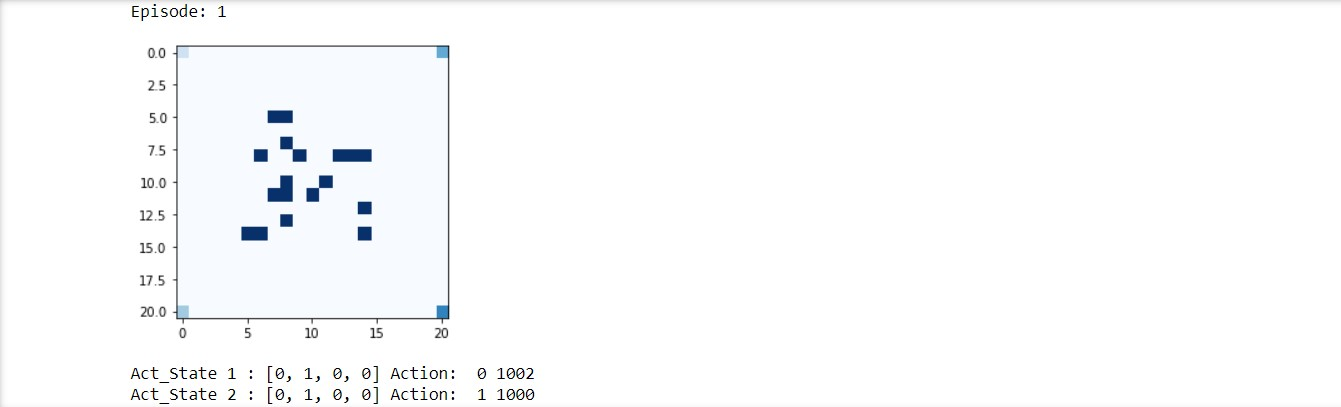

After few Episodes:

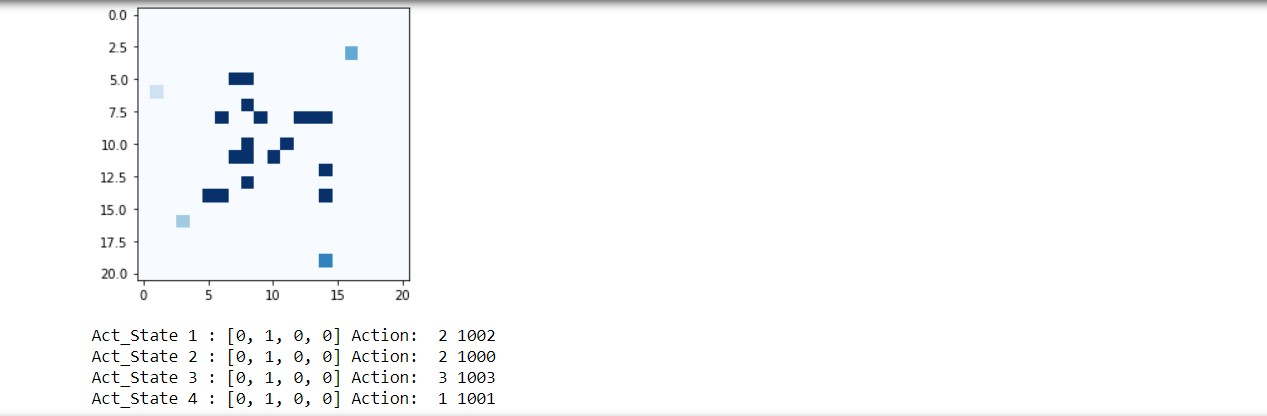

More Episodes

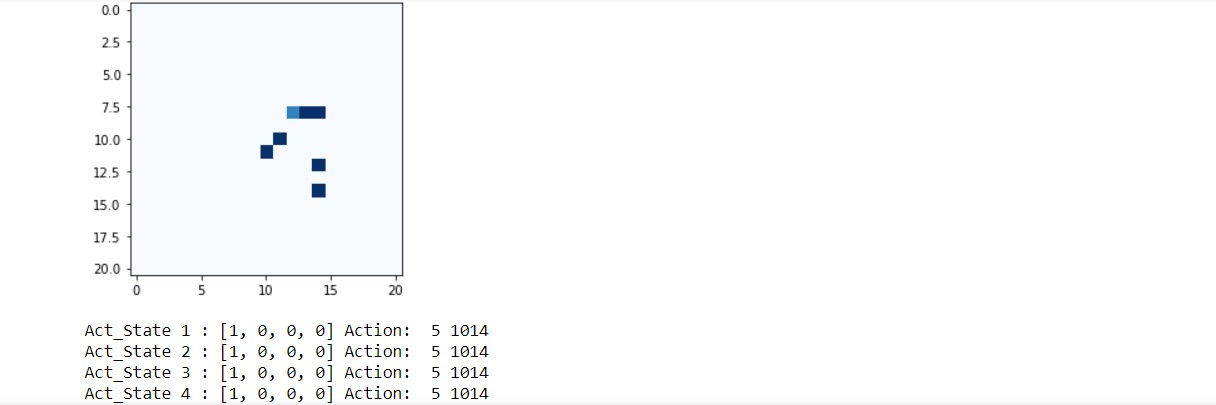

Last Episode. All fires are cleared!

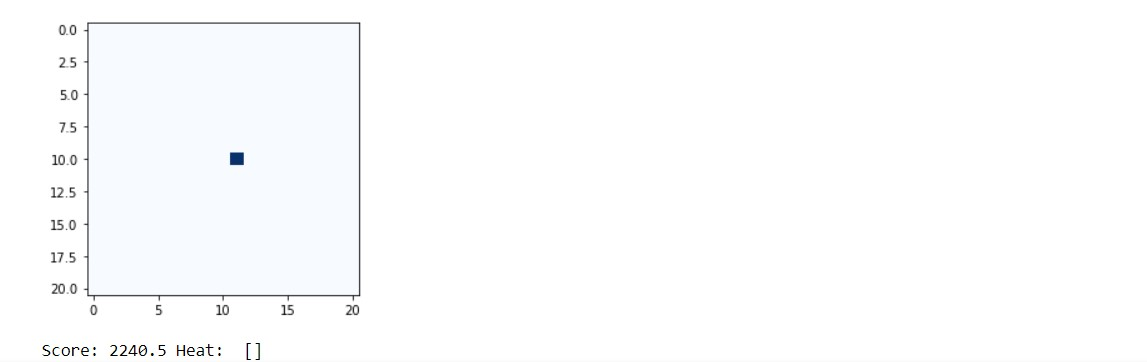